In [2]:
''' Creation: 2021.09.12
    Last update: 2021.09.20
    
    User specific paths definition
    
    '''

# Standard library imports
import os
from pathlib import Path

# 3rd party import
import pandas as pd

#Internal import 
import PVcharacterization_Utils as pv


# List of available bow data files
datafiles_list = pv.select_files()
#datafiles_list = list(datafiles_list)
#datafiles_list.sort()

list_files_descp = [pv.parse_filename(file) for file in datafiles_list]
    
df_files_descp  = pd.DataFrame(list_files_descp)

database_path = Path(os.path.dirname(datafiles_list[0])) / Path(pv.DATA_BASE_NAME)

pv.df2sqlite(df_files_descp, file=database_path, tbl_name=pv.DATA_BASE_TABLE)

print('df_files_descp and data base are built')

df_files_descp and data base are built


In [3]:
''' Creation: 2021.09.19
    Last update: 2021.09.20
    
    df_meta dataframe building from selected files in database DATA_BASE_NAME
    
    '''
# Standard library imports
import os

#Internal import 
import PVcharacterization_Utils as pv

pow_select = [200,400,600,800,1000,2000,4000]
name_select = ["DINERGY3272023326035","JINERGY3272023326035"]
time_select = ["T0", "T1", "T2"]

querries = pv.sieve_files(pow_select,time_select,name_select,database_path)

df_files_descp_copy = df_files_descp

df_files_descp_copy.index = [os.path.basename(x).split('.')[0] for x in df_files_descp_copy['file'].tolist()]
df_files_descp_copy = df_files_descp_copy.loc[:,['power','time','name'] ]

res = [pv.data_parsing(querry,parse_all=False).meta_data for querry in querries]
df_meta = pd.DataFrame.from_dict(res)
df_meta.index = df_meta['ID']
df_meta = df_meta.loc[:,pv.USED_COLS] # keep only USED_COLS defined in PVcharacterization_GUI.py

df_meta = pd.merge(df_meta,df_files_descp_copy,left_index=True, right_index=True) # add column

pv.df2sqlite(df_meta, file=database_path, tbl_name=pv.DATA_BASE_TABLE_EXP)

df_meta.head(3)

,Title,Voc,Isc,Rseries,Rshunt,Pmax,Vpm,Ipm,Fill Factor,power,time,name
ID,,,,,,,,,,,,
DINERGY3272023326035_0200W_T0,HET JNHM72 6x12 M2 0200W,50.5082,1.827,1.95841,1593.92,72.2867,42.5857,1.69744,0.78335,200,T0,DINERGY3272023326035
DINERGY3272023326035_0200W_T1,HET JNHM72 6x12 M2 0200W,50.6780,1.82484,1.87985,1874.07,72.5313,42.7868,1.69517,0.78429,200,T1,DINERGY3272023326035
DINERGY3272023326035_0200W_T2,HET DNHM72 6x12 M2 0200W,50.3452,1.79790,2.09313,875.055,71.105,42.5312,1.67182,0.78555,200,T2,DINERGY3272023326035


In [4]:
def set_min_max_param(df_meta,diff=False):
    
    if diff:
        min_max_param = pv.MIN_MAX_PARAM
    else:
        USED_COLS_copy = list(pv.USED_COLS)
        USED_COLS_copy.remove("Title")
        df_meta_ = df_meta.astype(dtype={col_name:float for col_name in USED_COLS_copy}, copy=True)
        df_stat = df_meta_.describe()
        min_max_param = {param:np.array(list(value.values()))
                        for param,value in df_stat.loc[['min','max'],:].to_dict().items()}
        min_max_param = {param:[x[0] - (ecart := np.diff(x)/2),x[1] + ecart]
                        for param,x in min_max_param.items()}
        
    return min_max_param

def plot_params(params, df_meta,diff=False):
    
    '''Plots for different experiments and for different parameters:
       - the relative  evolution (in %) of the parameters vs power for any time differences if diff=True
       - the parameters vs power for any times if diff=False
    The parameters values vs experiments (ID), time, power and are store in a dataframe like:
    
      ID                          Voc         Isc   Rseries   power time                                                         
   JINERGY3272023326035_0200W_T0  50.5082    1.827  1.95841     200   T0  
   JINERGY3272023326035_0200W_T1  50.6780  1.82484  1.87985     200   T1   
   JINERGY3272023326035_0200W_T2  50.3452  1.79790  2.09313     200   T2  
   JINERGY3272023326035_0400W_T0  51.8321  3.61464  1.05142     400   T0 
   
   Args:
       params (list of str): list of parameters to be plotted
       df_meta (dataframe): dataframe organized as above
       diff (bool): if true the parameters relative evolution in %, vs power, between every difference time are plotted
                    if false the parameters evolution  vs power are plotted

    '''

    # Standard library imports
    from itertools import combinations

    # 3rd party import
    import matplotlib.pyplot as plt
    import numpy as np
    
    color = ['#0000A0','#1569C7','#78f89d','#FFEB3B','#E64A19'] # markers color
                                                                #  different color per power
    marker = ["o", "v", ">", "<", "s", "p"]                     # maker symbol
                                                                #  different symbol per experiment
        
    list_exp = pd.unique(df_meta['name'])          # List of experiment name (ID)
    list_pow = sorted(pd.unique(df_meta['power'])) # List of power
    nbr_time = len(pd.unique(df_meta['time']))     # Number of different times
    assert nbr_time > 1, "not enough time measurements. Should be greeter than 1"
    
    # Set y dynamic of the plots
    if diff: # Plots relative variations of the parameters
        combination_length = 2
        dic_ylim = set_min_max_param(df_meta,diff=True)        
    else:
        combination_length = 1
        dic_ylim = set_min_max_param(df_meta,diff=False)
    
    #  Set x dynamic of the plots (enlarge the power dynamic)
    pow_add_nbr = 2
    pow_add = pow_add_nbr * (max(list_pow) - min(list_pow))
    pow_min, pow_max = (
        min(list_pow) -  pow_add,
        max(list_pow) +  pow_add,
    )

    
    fig = plt.figure(figsize=(15,15) if len(params)>1 else (10,5))
    gs = fig.add_gridspec(
        len(params),
        int(nbr_time * (nbr_time - 1) / 2) if diff else nbr_time,
        hspace=0,
        wspace=0
    )

    ax = gs.subplots(sharex="col", sharey="row")
    if len(params) ==1: # we trasform a 1D array to a 2D array
        ax = ax.reshape((1,np.shape(ax)[0]))

    for idx_exp, exp in enumerate(list_exp): # Loop on the experiments
        
        df_exp = df_meta.query("name == @exp")

        # split df_exp into a dic keyed by time (T0,T1,...). The values are dataframe df_exp
        # with column time=T0,T1,...
        list_t = sorted(pd.unique(df_exp['time']))
        dic_time = {time : df_exp.loc[df_exp["time"] == time, :] for time in list_t}
        

        for idx_param, param in enumerate(params): # Loop on the parameter
            dic_time_cp = {}

            for time in combinations(list_t, combination_length): # Loop on time difference
                if combination_length>1 :
                    val = np.array(dic_time[time[1]][param].astype(float).tolist())
                    ref = np.array(dic_time[time[0]][param].astype(float).tolist())
                    delta = 100 * (val - ref) / ref
                    dic_time_cp[time[1] + "-" + time[0]] = dic_time[time[1]].copy()
                    dic_time_cp[time[1] + "-" + time[0]]["Delta_" + param] = delta
                else:
                    dic_time_cp[time[0]] = dic_time[time[0]].copy()
                    dic_time_cp[time[0]]["Delta_" + param] = np.array(dic_time[time[0]][param].astype(float).tolist())

            list_times_diff = sorted(dic_time_cp.keys())
    
            for idx_time, key in enumerate(list_times_diff):
                for idx_power,x_y in enumerate(zip(dic_time_cp[key]["power"],
                                                   dic_time_cp[key]["Delta_" + param])):
                    ax[idx_param, idx_time].scatter(
                            x_y[0],
                            x_y[1],
                            c=color[idx_power] ,
                            marker=marker[idx_exp],
                            label=exp+' '+str(x_y[0])
                        )


                if diff: ax[idx_param, idx_time].axhline(y=0, color="red", linestyle="--")
                if idx_param == 0:
                    ax[idx_param, idx_time].set_title(key)
                ax[idx_param, idx_time].set_xlabel("Power ($W/{m^2}$)")
                if idx_time == 0:
                    if combination_length > 1:
                        ax[idx_param, idx_time].set_ylabel("$\Delta$ " + param + " (%)")
                    else:
                        ax[idx_param, idx_time].set_ylabel(f'{param} ({pv.PARAM_UNIT_DIC[param]})')
                ax[idx_param, idx_time].tick_params(axis="x", rotation=90)
                ax[idx_param, idx_time].set_xticks(list_pow, minor=False)
                ax[idx_param, idx_time].set_xticklabels(list_pow, fontsize=12)
                ax[idx_param, idx_time].set_xlim([pow_min, pow_max])
                ax[idx_param, idx_time].set_ylim(dic_ylim.get(param,[-3.2, 1.6]))
                for axis in ["top", "bottom", "left", "right"]:
                    ax[idx_param, idx_time].spines[axis].set_linewidth(2)
                    
    handles, labels = ax[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right',bbox_to_anchor=(0.6,0, 0.5, 1))
    #title = chr(9679) + " " + list_exp[0]
    #if len(list_exp) ==2 : title = title + ', ' + chr(9660) + " " + list_exp[1]
    #fig.suptitle(title, fontsize=13)
    #fig.subplots_adjust(top=0.95 if len(params)>1 else 0.85)

WARNING parameter trarmiz will be ignored
WARNING parameter bidon will be ignored


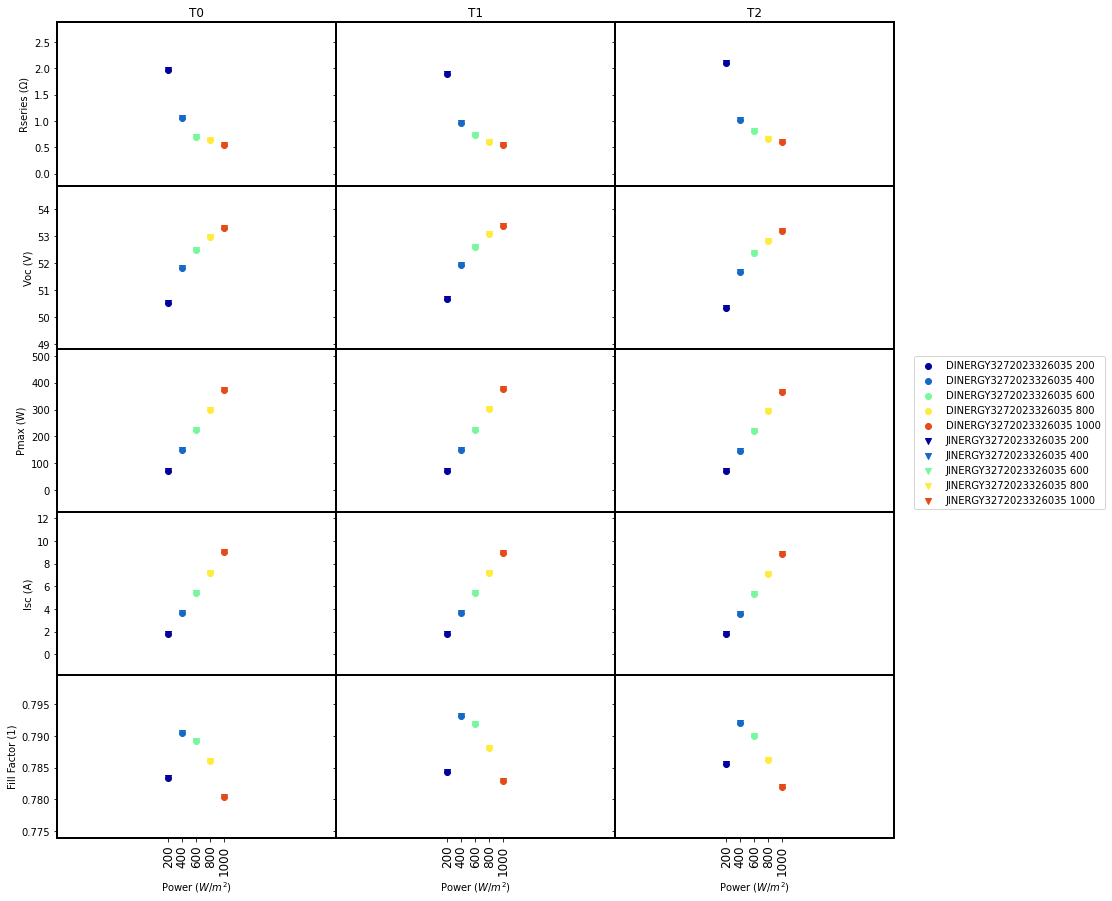

In [5]:
''' Creation: 2021.09.19
    Last update: 2021.10.03
    
    Plotting of parameters evolution.
    
    '''

#Internal import 
import PVcharacterization_Utils as pv

params = ['Pmax','Voc','Isc','Fill Factor','Rseries','bidon','trarmiz']

unkown_params = set(params).difference(set(pv.USED_COLS))
for unknow_param in unkown_params:
    print(f'WARNING parameter {unknow_param} will be ignored')
    
params = set(pv.USED_COLS).intersection(set(params)) 

plot_params(params,df_meta,diff=False)


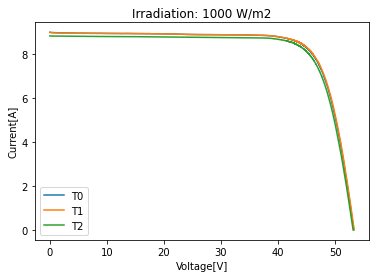

In [6]:
''' Creation: 2021.09.19
    Last update: 2021.09.20
    
    Plotting of I/V curves.
    
    '''

# 3rd party import
import matplotlib.pyplot as plt

#Internal import 
import PVcharacterization_Utils as pv

pow_select = [1000]
name_select = ["JINERGY3272023326035",]
time_select = ["T0","T1","T2"]

querries = pv.sieve_files(pow_select,time_select,name_select,database_path)

for i, res in enumerate([pv.data_parsing(querry).IV0 for querry in querries]):
    plt.plot(res['Voltage'],res['Current'],label=time_select[i])
    plt.xlabel(res.columns[0] +'[V]')
    plt.ylabel(res.columns[1] +'[A]')
    plt.title(f'Irradiation: {str(pow_select[0])} {pv.PARAM_UNIT_DIC["IrrCorr"]}')
    
plt.legend()
plt.show()

    

In [7]:
import sqlite3
from string import Template

time_select = ['T0']
name = ['DINERGY3272023326035']
conv2str = lambda list_: str(tuple(list_)).replace(",)", ")")

conn = sqlite3.connect(database_path)
cur = conn.cursor()

querry_d = Template(
    """SELECT Pmax, power
       FROM $table_name 
       WHERE
       time IN $time_select
       AND name IN $name
                   """
)

cur.execute(
    querry_d.substitute(
        {
            "table_name": pv.DATA_BASE_TABLE_EXP,
            "time_select": conv2str(time_select),
            "name": conv2str(name)
        }
    )
)

res = cur.fetchall()
Pmax = [float(x[0]) for x in res]
power = [float(x[1]) for x in res]
cur.close()
conn.close()
Pmax, power

([72.2867, 148.082, 223.513, 298.946, 373.96],
 [200.0, 400.0, 600.0, 800.0, 1000.0])